# Churn Prediction in Telecom Industry

If you have a look at the European Business review statistics, it is mindblowing that telecommunication providers lose almost $65 million a month from customer churn which is way tooo expensive. It also contributes to one of the biggest problem in the industry.

This project tries to predict churn in the telecom industry.

## Importing libraries and packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid', color_codes=True)
import xgboost as xgb
from xgboost import plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import category_encoders as ce
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.impute import SimpleImputer

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

## Loading the dataset

In [3]:
df = pd.read_csv(r'C:\Users\user\Desktop\__PYTHON__\Datasets\WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## EDA

In [4]:
df.shape

(7043, 21)

In [5]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


The TotalCharges column is an object type which is not supposed to be. I'll be converting it to a numeric type.

In [7]:
df.TotalCharges = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [8]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [18]:
# mean_imputer = SimpleImputer(strategy="mean")
# df['TotalCharges'] = mean_imputer.fit_transform(df['TotalCharges'].values.reshape(-1,1))

#### Summary of the non-null columns in the dataset

In [9]:
null = df.isnull().sum().sort_values(ascending=False)
n1 = df.isnull().sum()/df.isnull().count()*100
n2 = (np.round(n1, 1)).sort_values(ascending=False)
missing_val = pd.concat([null, n2], axis=1, keys=['Total null', 'Percent(%)'])
missing_val

,Total null,Percent(%)
TotalCharges,11,0.2
customerID,0,0.0
DeviceProtection,0,0.0
MonthlyCharges,0,0.0
PaymentMethod,0,0.0
PaperlessBilling,0,0.0
Contract,0,0.0
StreamingMovies,0,0.0
StreamingTV,0,0.0
TechSupport,0,0.0


#### A quick viz of the dataset's categorical columns

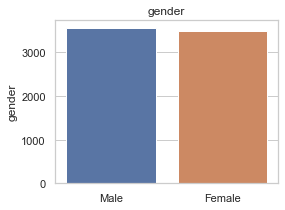

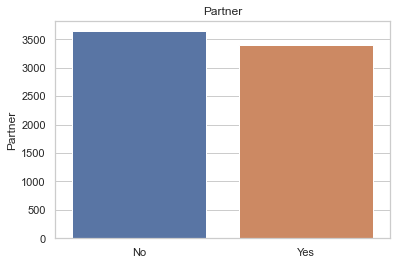

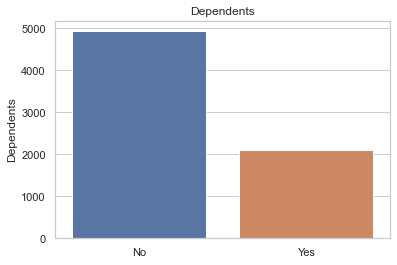

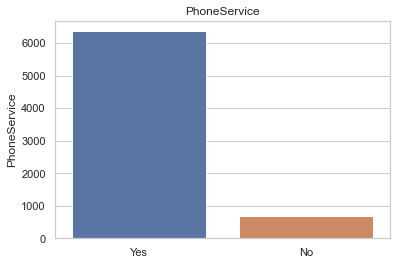

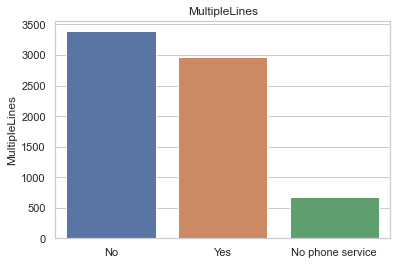

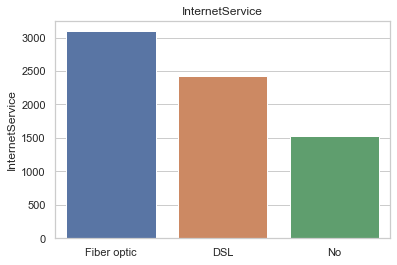

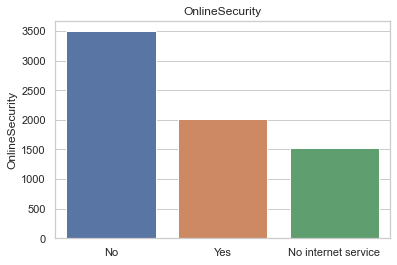

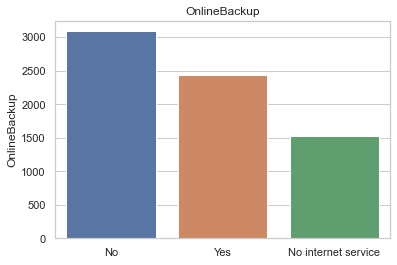

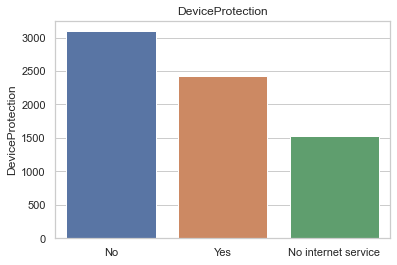

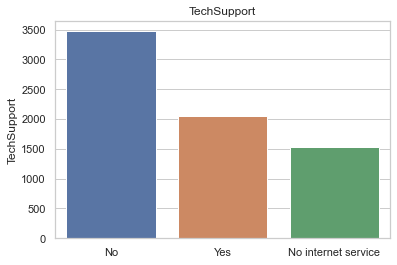

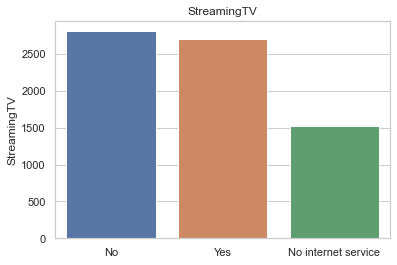

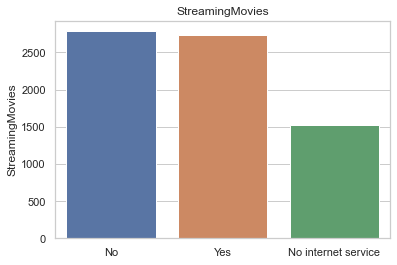

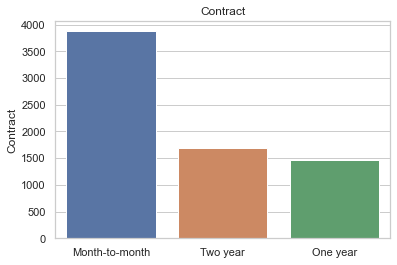

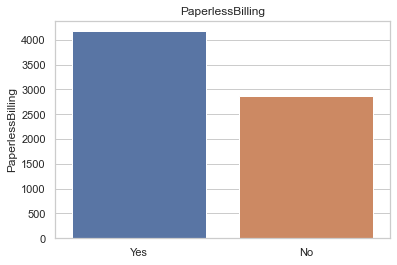

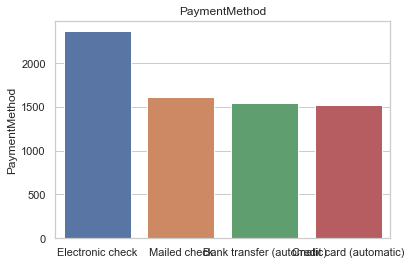

In [10]:
plt.figure(figsize=(4, 3))
review = df[['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']]
for i in review.columns:
    sns.barplot(x=review[i].value_counts().index, y=review[i].value_counts()).set_title(i)
    plt.show()

## Further Analysis

### Churn

Text(0, 0.5, 'No of customers')

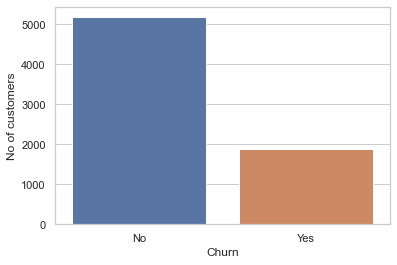

In [11]:
sns.countplot(x=df['Churn'])
plt.ylabel('No of customers')

Majority of customers experienced a negative churn

#### Churn based on Gender

Text(0.5, 1.0, 'Churn by Female')

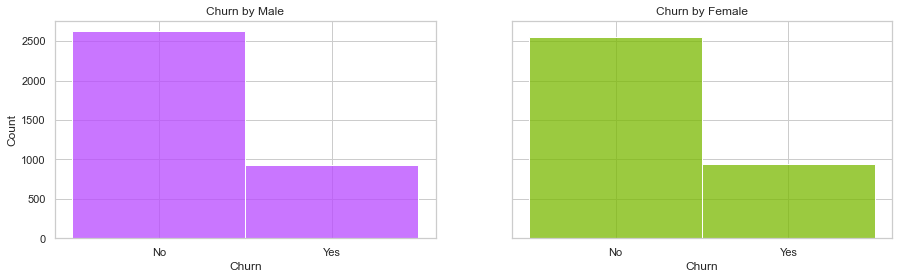

In [12]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharey = True, figsize=(15,4))

ax = sns.histplot(df[df['gender']=='Male']['Churn'], kde=False, color = '#B848FF', ax=ax1)
ax.set_title('Churn by Male')
ax = sns.histplot(df[df['gender']=='Female']['Churn'], kde=False, color = '#7AB900', ax=ax2)
ax.set_title('Churn by Female')

Text(0.5, 1.0, 'Churn by Female')

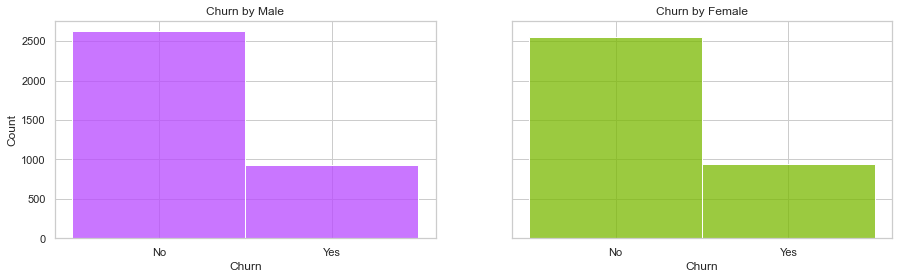

In [13]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharey = True, figsize=(15,4))

ax = sns.histplot(df[df['gender']=='Male']['Churn'], kde=False, color = '#B848FF', ax=ax1)
ax.set_title('Churn by Male')
ax = sns.histplot(df[df['gender']=='Female']['Churn'], kde=False, color = '#7AB900', ax=ax2)
ax.set_title('Churn by Female')

### Gender

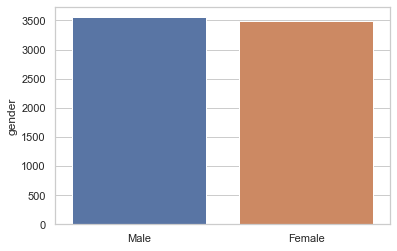

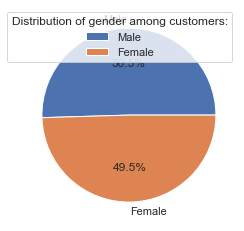

In [14]:
sns.barplot(x=df['gender'].value_counts().index, y=df['gender'].value_counts())
plt.figure(figsize=(4, 4))
plt.pie(x=df['gender'].value_counts(),autopct='%1.1f%%', labels=['Male', 'Female'], )
plt.legend(title = 'Distribution of gender among customers:')

From the above, the majority of the customers is seen to be Male. 

### Partner

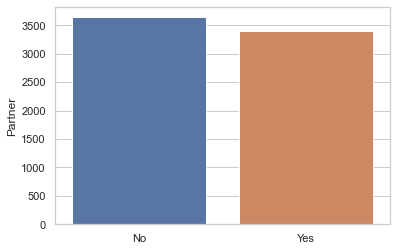

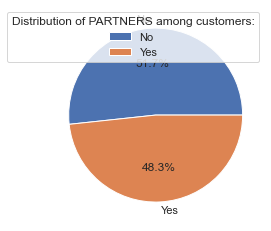

In [15]:
sns.barplot(x=df['Partner'].value_counts().index, y=df['Partner'].value_counts())
plt.figure(figsize=(4, 4))
plt.pie(x=df['Partner'].value_counts(),autopct='%1.1f%%', labels=['No', 'Yes'], )
plt.legend(title = 'Distribution of PARTNERS among customers:')

Majority of the customers have partners. (51.7%)

### Senior Citizen

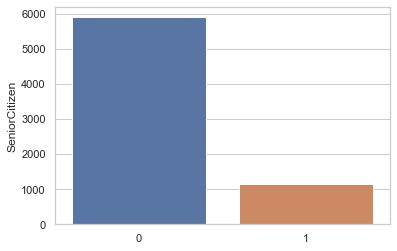

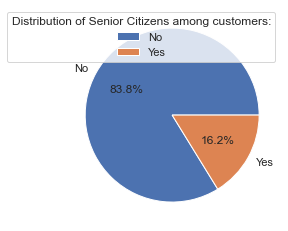

In [16]:
sns.barplot(x=df['SeniorCitizen'].value_counts().index, y=df['SeniorCitizen'].value_counts())
plt.figure(figsize=(4, 4))
plt.pie(x=df['SeniorCitizen'].value_counts(),autopct='%1.1f%%', labels=['No', 'Yes'], )
plt.legend(title = 'Distribution of Senior Citizens among customers:')

16.2%(1142) of the customers were younger people while 83.8%(5901) were Senior Citizens

### Dependents

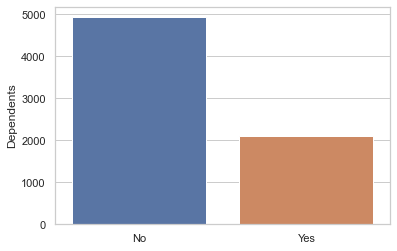

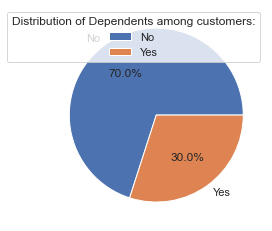

In [17]:
sns.barplot(x=df['Dependents'].value_counts().index, y=df['Dependents'].value_counts())
plt.figure(figsize=(4, 4))
plt.pie(x=df['Dependents'].value_counts(),autopct='%1.1f%%', labels=['No', 'Yes'], )
plt.legend(title = 'Distribution of Dependents among customers:')

Few of the customers actually have dependents

### Customer Services

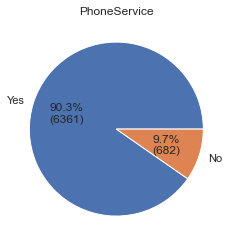

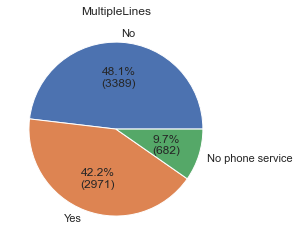

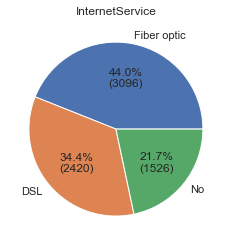

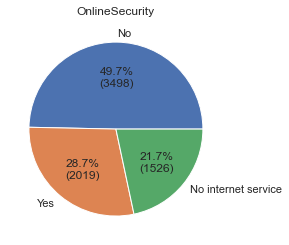

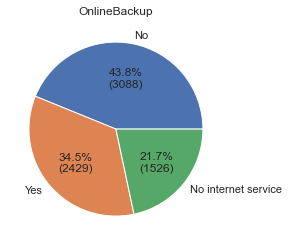

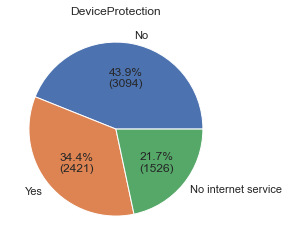

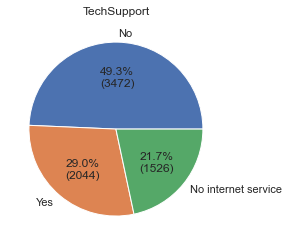

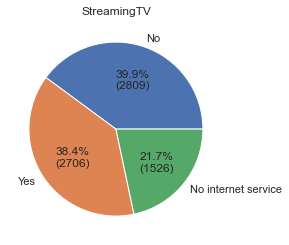

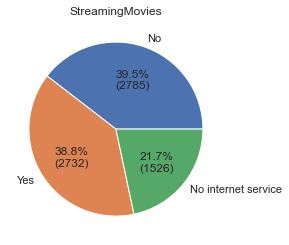

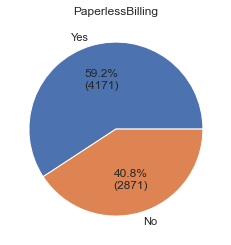

In [18]:
def func(pct, allvalues):
    abs = int(pct/100.*np.sum(allvalues))
    return '{:.1f}%\n({:d})'.format(pct, abs)

review = df[['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']]
for i in review.columns:
    plt.pie(x=review[i].value_counts(), labels=review[i].value_counts().index, autopct=
           lambda pct: func(pct, review[i].value_counts().values))
    # sns.barplot(x=review[i].value_counts().index, y=review[i].value_counts()).set_title(i)
    plt.title(i)
    plt.show()

### Contract

Text(0.5, 0, 'Contract')

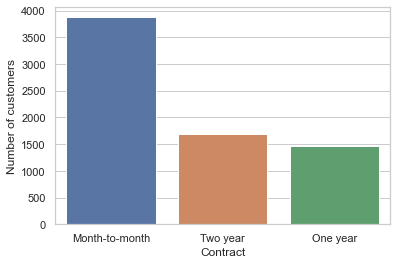

In [19]:
sns.barplot(x=df['Contract'].value_counts().index, y=df['Contract'].value_counts())
plt.ylabel('Number of customers')
plt.xlabel('Contract')

The `Month-to-month` is the contractual situation of most customers

#### Contract based on Tenure

In [20]:
# df[df['Contract']=='Month-to-month']['tenure']

Text(0.5, 1.0, 'Two year Contract')

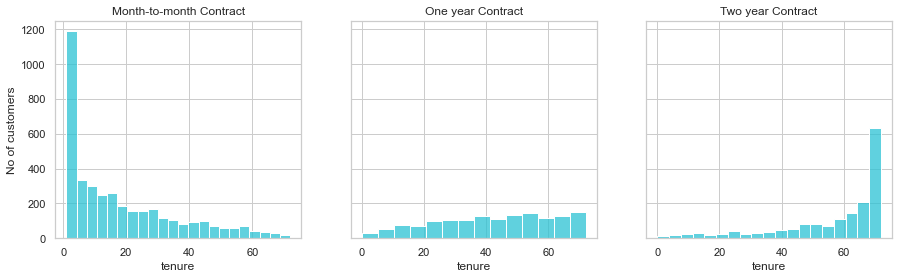

In [21]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize=(15,4))

ax = sns.histplot(df[df['Contract']=='Month-to-month']['tenure'], kde=False, color = '#2BC2D3', ax=ax1)
ax.set_ylabel('No of customers')
ax.set_title('Month-to-month Contract')
ax = sns.histplot(df[df['Contract']=='One year']['tenure'], kde=False, color = '#2BC2D4', ax=ax2)
ax.set_ylabel('No of customers')
ax.set_title('One year Contract')
ax = sns.histplot(df[df['Contract']=='Two year']['tenure'], kde=False, color = '#2BC2D5', ax=ax3)
ax.set_ylabel('No of customers')
ax.set_title('Two year Contract')

#### Contract based on Churn

Text(0.5, 1.0, 'Two year Contract')

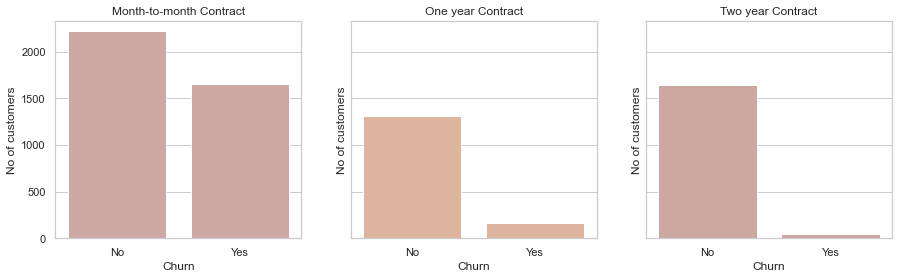

In [22]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize=(15,4))

ax = sns.countplot(x=df[df['Contract']=='Month-to-month']['Churn'], color='#D4A29D', ax=ax1)
ax.set_ylabel('No of customers')
ax.set_title('Month-to-month Contract')
ax = sns.countplot(x=df[df['Contract']=='One year']['Churn'], color='#E8B293', ax=ax2)
ax.set_ylabel('No of customers')
ax.set_title('One year Contract')
ax = sns.countplot(x=df[df['Contract']=='Two year']['Churn'], color='#D4A29A', ax=ax3)
ax.set_ylabel('No of customers')
ax.set_title('Two year Contract')

#### Contract based on Gender

Text(0.5, 1.0, 'Two year Contract')

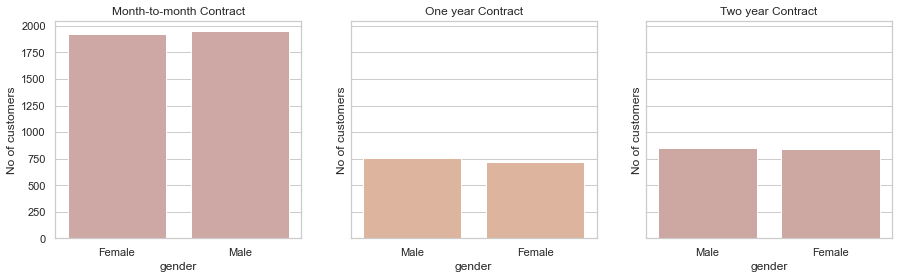

In [23]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize=(15,4))

ax = sns.countplot(x=df[df['Contract']=='Month-to-month']['gender'], color='#D4A29D', ax=ax1)
ax.set_ylabel('No of customers')
ax.set_title('Month-to-month Contract')
ax = sns.countplot(x=df[df['Contract']=='One year']['gender'], color='#E8B293', ax=ax2)
ax.set_ylabel('No of customers')
ax.set_title('One year Contract')
ax = sns.countplot(x=df[df['Contract']=='Two year']['gender'], color='#D4A29A', ax=ax3)
ax.set_ylabel('No of customers')
ax.set_title('Two year Contract')

### Charges

The charges consists of the Monthly Charges and the Total Charges

<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

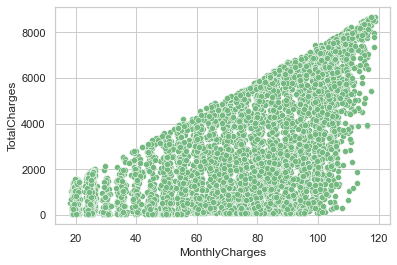

In [25]:
sns.scatterplot(x=df['MonthlyCharges'], y=df['TotalCharges'], palette='Set3', color='#74B97F')

### Payment Methods

In [26]:
df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

<AxesSubplot:ylabel='PaymentMethod'>

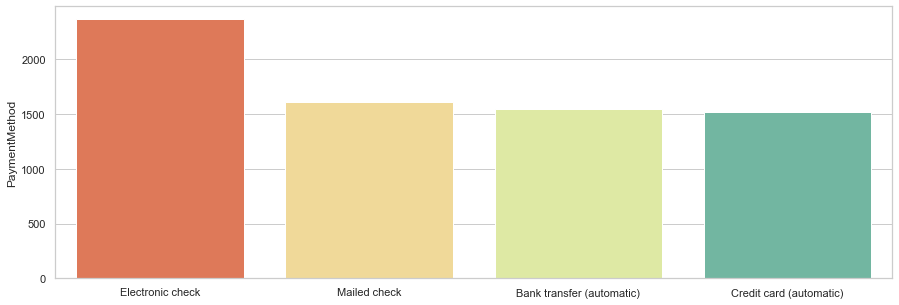

In [27]:
plt.figure(figsize=(15, 5))
sns.barplot(x=df['PaymentMethod'].value_counts().index, y=df['PaymentMethod'].value_counts(), palette='Spectral')

The electronic check is the most common method of payment

## Model Training

### Converting the target categorical variable to numerical

The churn is the target column in the dataset. I'll be converting it to an integer data type.

In [28]:
churn_num = {'Yes': 1, 'No': 0}
df['Churn'] = df['Churn'].map(churn_num)
df['Churn'].unique()

array([0, 1], dtype=int64)

Setting the input and output features.

In [29]:
X = df.drop(['Churn', 'customerID'], axis=1)
y = df['Churn']

### Converting categorical variables to numeric data

In [45]:
warnings.filterwarnings('ignore')
cat_pipeline = Pipeline(
    steps=[
        ('target encoding', ce.TargetEncoder())
    ]
)

### Scaling numerical features and filling missing values

In [46]:
num_pipeline = Pipeline(
    steps=[('impute', SimpleImputer(strategy='mean')),
          ('scale', StandardScaler())]
)

### Numerical and categorical feature names

In [47]:
cat_cols = X.select_dtypes(exclude='number').columns
num_cols = X.select_dtypes(include='number').columns

In [48]:
print('Categorical columns:\n', cat_cols);print()
print('Numeric columns:\n',num_cols)

Categorical columns:
 Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

Numeric columns:
 Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')


### Combining the two pipelines with a column transformer

In [49]:
from sklearn.compose import ColumnTransformer
full_pipeline = ColumnTransformer(
    transformers=[
        ('numeric', num_pipeline, num_cols),
        ('categorical', cat_pipeline, cat_cols)
    ]
)

In [50]:
warnings.filterwarnings('ignore')
X_ = full_pipeline.fit_transform(X, y)
y_ = y.values.reshape(-1,1)

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X_, y_, stratify=y_, random_state=101)

In [58]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5282, 19) (5282, 1)
(1761, 19) (1761, 1)


### XGBoost

In [129]:
warnings.filterwarnings('ignore')
xgb_cl = xgb.XGBClassifier(eta= 0.02, eval_metric='mlogloss', objective='binary:logistic', max_depth=7, n_estimators=120, 
                           n_jobs=-1, colsample_bytree=0.5,  reg_alpha=0.8, gamma=1)


#### Using Cross validation

In [123]:
accuracy = cross_val_score(xgb_cl, X_train, y_train, cv=10, scoring='accuracy')
print(accuracy)
print('accuracy = {:.4f} %'.format(accuracy.mean()*100))
print('std = {:.4f} %'.format(accuracy.std()*100))

[0.78827977 0.83742911 0.82007576 0.79924242 0.81628788 0.78409091
 0.80113636 0.81818182 0.79924242 0.8030303 ]
accuracy = 80.6700 %
std = 1.5340 %


In [124]:
def cross_validation(model, _X, _y, _cv=5):
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Mean Training Precision": results['train_precision'].mean(),
              "Mean Training Recall": results['train_recall'].mean(),
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Mean Validation Precision": results['test_precision'].mean(),
              "Mean Validation Recall": results['test_recall'].mean(),
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [125]:
xgb_result = cross_validation(xgb_cl, X_train, y_train, 10)
xgb_result

{'Training Accuracy scores': array([0.85419735, 0.85146223, 0.85044173, 0.85591081, 0.85359697,
        0.85527976, 0.85759361, 0.85464872, 0.85696256, 0.85612116]),
 'Mean Training Accuracy': 85.46214905255243,
 'Mean Training Precision': 0.7818427026133901,
 'Mean Training Recall': 0.6274358387866646,
 'Mean Training F1 Score': 0.6961364865928068,
 'Validation Accuracy scores': array([0.78827977, 0.83742911, 0.82007576, 0.79924242, 0.81628788,
        0.78409091, 0.80113636, 0.81818182, 0.79924242, 0.8030303 ]),
 'Mean Validation Accuracy': 80.66996763475969,
 'Mean Validation Precision': 0.6732618609583201,
 'Mean Validation Recall': 0.5313829787234042,
 'Mean Validation F1 Score': 0.5928967094001258}

The model has an accuracy score of 81%

### CatBoost

In [163]:
warnings.filterwarnings('ignore')
import catboost as cb

cat_cl = cb.CatBoostClassifier(verbose=False, learning_rate=0.34, iterations=100, max_depth=3)

#### Using Cross validation

In [164]:
accuracy = cross_val_score(cat_cl, X_train, y_train, cv=10, scoring='accuracy')
print(accuracy)
print('accuracy = {:.4f} %'.format(accuracy.mean()*100))
print('std = {:.4f} %'.format(accuracy.std()*100))

[0.81663516 0.83931947 0.81439394 0.79166667 0.82007576 0.79545455
 0.79356061 0.80492424 0.8030303  0.80113636]
accuracy = 80.8020 %
std = 1.3986 %


In [165]:
def cross_validation(model, _X, _y, _cv=5):
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Mean Training Precision": results['train_precision'].mean(),
              "Mean Training Recall": results['train_recall'].mean(),
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Mean Validation Precision": results['test_precision'].mean(),
              "Mean Validation Recall": results['test_recall'].mean(),
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [166]:
cb_result = cross_validation(cat_cl, X_train, y_train, 10)
cb_result

{'Training Accuracy scores': array([0.83399958, 0.82600463, 0.82562053, 0.82919647, 0.82982751,
        0.83340345, 0.83550694, 0.8327724 , 0.8340345 , 0.83045856]),
 'Mean Training Accuracy': 83.10824569669305,
 'Mean Training Precision': 0.7200234379959779,
 'Mean Training Recall': 0.5951013018872905,
 'Mean Training F1 Score': 0.6515931222189523,
 'Validation Accuracy scores': array([0.81663516, 0.83931947, 0.81439394, 0.79166667, 0.82007576,
        0.79545455, 0.79356061, 0.80492424, 0.8030303 , 0.80113636]),
 'Mean Validation Accuracy': 80.80197055622386,
 'Mean Validation Precision': 0.6684880632744358,
 'Mean Validation Recall': 0.552031408308004,
 'Mean Validation F1 Score': 0.6041967265461174}

XGBoost appears to be the best model